# From attention to transformers


ORIGINICAL CODE is BASED ON IMPLIMENTATIONS BY HUGGING FACE. THIS CODE AND ITS ENTIRITY IS PROVIVDED AS A TUTORIAL OR FOR TEACHING PURPOSES ONLY AS PART OF THE COMPUTER VISION COURSE.

Reference: Tutorial for Harvard Medical School ML from Scratch Series: Transformer from Scratch (https://github.com/Animadversio/TransformerFromScratch?tab=readme-ov-file).



### General note for GPU training (in colab)

* First, please use the GPU runtime. If so the `!nvidia-smi` will return no error.
  1. Click on "Runtime" in the top menu bar.
  2. Select "Change runtime type" from the drop-down menu.
  3. In the "Runtime type" section, select "GPU" as the hardware accelerator.
  4. Click "Save" to apply the changes.


* What should I do with **Cuda out of memory error.**? (this is THE most common error in DL)
![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*enMsxkgJ1eb9XvtWju5V8Q.png)
  1. In colab notebook, **unfortunately, you need to restart the kernel after OOM happened**. Or it will keep happening no matter what.
  2. Change the model to save memory, usually includes, decrease batch size, decrease the number of layers, decrease the max sequence length, decrease the hidden / embedding dimension
  3. If you know mixed precision training, you can switch to low precision `fp16` numbers for weights and inputs.

* What should I do for the **Device siee assert triggered** error
  > RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
  
  * Usually it's because the embedding layer receive an index (token id or position id) not stored in it.
  * Could be sth. else, which will be harder to debug...

In [117]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8" # to fix a potential locale bug
!nvidia-smi

Mon Feb 19 22:51:35 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:C1:00.0 Off |                    0 |
| N/A   64C    P0   261W / 300W |   6572MiB /  7629MiB |     50%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports

In [118]:
!pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

In [119]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Self-Attention Mechanism: Single Head

![](https://raw.githubusercontent.com/Animadversio/TransformerFromScratch/main/media/AttentionSchematics_white-01.png)

In [121]:
embdim = 256
headdim = 64
tokens = torch.randn(1, 5, embdim) # batch, tokens, embedding
Wq = torch.randn(embdim, headdim) / math.sqrt(embdim)
Wk = torch.randn(embdim, headdim) / math.sqrt(embdim)
Wv = torch.randn(embdim, embdim) / math.sqrt(embdim)

## FILLED in:  the score matrix computation

In [122]:
qis = torch.einsum("BSE,EH->BSH", tokens, Wq) # batch x seqlen x headdim
kis = torch.einsum("BTE,EH->BTH", tokens, Wk) # batch x seqlen x headdim
vis = torch.einsum("BTE,EF->BTF", tokens, Wv) # batch x seqlen x embeddim
#### ------ Add your code here:compute query-key similarities. ------ ####
#scoremat =  # output: batch x seqlen (Query) x seqlen (Key)

scoremat = torch.einsum("BSH,BTH->BST",qis,kis) # output: batch x seqlen (Query) x seqlen (Key)
#### ------ End ------ ####
attmat = F.softmax(scoremat / math.sqrt(headdim), dim=2)

Some checks to make sure the score correspond to the product of the right pair.

In [123]:
assert(torch.isclose(scoremat[0,1,2], qis[0,1,:]@kis[0,2,:]))
assert(torch.isclose(scoremat[0,3,4], qis[0,3,:]@kis[0,4,:]))
assert(torch.isclose(scoremat[0,2,2], qis[0,2,:]@kis[0,2,:]))

In [124]:
zis = torch.einsum("BST,BTF->BSF", attmat, vis)

In pytorch, these operations are packed int the function `F.scaled_dot_product_attention`. So let's test our implementation of the single head attention against it.

In [125]:
attn_torch = F.scaled_dot_product_attention(qis,kis,vis)
assert(torch.allclose(attn_torch, zis, atol=1E-6,rtol=1E-6))

## Multi-head attention

In [126]:
embdim = 768
headcnt = 12
headdim = embdim // headcnt
assert headdim * headcnt == embdim
tokens = torch.randn(1, 5, embdim) # batch, tokens, embedding
Wq = torch.randn(embdim, headcnt * headdim) / math.sqrt(embdim) # heads packed in a single dim
Wk = torch.randn(embdim, headcnt * headdim) / math.sqrt(embdim) # heads packed in a single dim
Wv = torch.randn(embdim, headcnt * headdim) / math.sqrt(embdim) # heads packed in a single dim

In [127]:
batch, token_num, _ = tokens.shape
qis = torch.einsum("BSE,EH->BSH", tokens, Wq)
kis = torch.einsum("BTE,EH->BTH", tokens, Wk)
vis = torch.einsum("BTE,EH->BTH", tokens, Wv)
# split the single hidden dim into the heads
qis_mh = qis.view(batch, token_num, headcnt, headdim)
kis_mh = kis.view(batch, token_num, headcnt, headdim)
vis_mh = vis.view(batch, token_num, headcnt, headdim)

## Computed:  multihead attention using `einsum`

In [128]:
#### ------ Add your code here: compute query-key similarities. ------ ####
#scoremat_mh =   # Output: batch x headcnt x seqlen (query) x seqlen (key)

scoremat_mh = torch.einsum("BSHD,BTHD->BHST",qis_mh,kis_mh) 

#### ------ End ------ ####
attmat_mh = F.softmax(scoremat_mh / math.sqrt(headdim), dim=-1)
zis_mh = torch.einsum("BCST,BTCH->BSCH", attmat_mh, vis_mh)  # batch x seqlen (query) x headcnt x headdim
zis = zis_mh.reshape(batch, token_num, headcnt * headdim)

Let's validate the tensor multiplication is correct

In [129]:
# raw attention score of the 1st attention head
assert (torch.allclose(scoremat_mh[0, 1], qis_mh[0,:,1] @ kis_mh[0,:,1,:].T))

In [130]:
print(tokens.shape)
print(qis_mh.shape)
print(kis_mh.shape)
print(vis_mh.shape)
print(attmat_mh.shape)
print(zis_mh.shape)
print(zis.shape)

torch.Size([1, 5, 768])
torch.Size([1, 5, 12, 64])
torch.Size([1, 5, 12, 64])
torch.Size([1, 5, 12, 64])
torch.Size([1, 12, 5, 5])
torch.Size([1, 5, 12, 64])
torch.Size([1, 5, 768])


In `torch` this operation is packed in `nn.MultiheadAttention`, including the input projection, attention and out projection. So, note the input the the `mha.forward` function are the *token_embeddings* not the Q,K,Vs as we put it in `F.scaled_dot_product_attention`

In [131]:
mha = nn.MultiheadAttention(embdim, headcnt, batch_first=True,)
print(mha.in_proj_weight.shape) # 3 * embdim x embdim
mha.in_proj_weight.data = torch.cat([Wq, Wk, Wv], dim=1).T

torch.Size([2304, 768])


In [132]:
attn_out, attn_weights = mha(tokens, tokens, tokens, average_attn_weights=False,)
assert torch.allclose(attmat_mh, attn_weights, atol=1e-6, rtol=1e-6)

In `nn.MultiheadAttention` , there is a output projection `out_proj`, projecting the values. It is a linear layer with bias. We can validate that going through this projection our outputs `zis` is the same as the output of `mha`

In [133]:
print(mha.out_proj)
assert torch.allclose(attn_out, mha.out_proj(zis), atol=1e-6, rtol=1e-6)

NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)


### Causal attention mask

For models such as GPT, each token can only attend to tokens before it, thus the attention score needs to be modified before entering softmax.

The common way of masking is to add a large negative number to the locations that you'd not want the model to attend to.

In [134]:
attn_mask = torch.ones(token_num,token_num,)
attn_mask = -1E4 * torch.triu(attn_mask,1)
attn_mask

tensor([[    -0., -10000., -10000., -10000., -10000.],
        [    -0.,     -0., -10000., -10000., -10000.],
        [    -0.,     -0.,     -0., -10000., -10000.],
        [    -0.,     -0.,     -0.,     -0., -10000.],
        [    -0.,     -0.,     -0.,     -0.,     -0.]])

In [135]:
scoremat_mh_msk = torch.einsum("BSCH,BTCH->BCST", qis_mh, kis_mh)  # batch x headcnt x seqlen (query) x seqlen (key)
scoremat_mh_msk += attn_mask  # add the attn mask to the scores before SoftMax normalization
attmat_mh_msk = F.softmax(scoremat_mh_msk / math.sqrt(headdim), dim=-1)
zis_mh_msk = torch.einsum("BCST,BTCH->BSCH", attmat_mh_msk, vis_mh)  # batch x seqlen (query) x headcnt x headdim
zis_msk = zis_mh_msk.reshape(batch, token_num, headcnt * headdim)

**Note** `is_causal` parameter should work and create a causal mask automatically. But in a recent pytorch bug, it doesn't work. So beware~
https://github.com/pytorch/pytorch/issues/99282

In [136]:
attn_out_causal, attn_weights_causal = mha(tokens, tokens, tokens, average_attn_weights=False, attn_mask=attn_mask)

In [137]:
assert torch.allclose(attn_weights_causal, attmat_mh_msk, atol=1e-6, rtol=1e-6)
assert torch.allclose(attn_out_causal, mha.out_proj(zis_msk), atol=1e-6, rtol=1e-6)

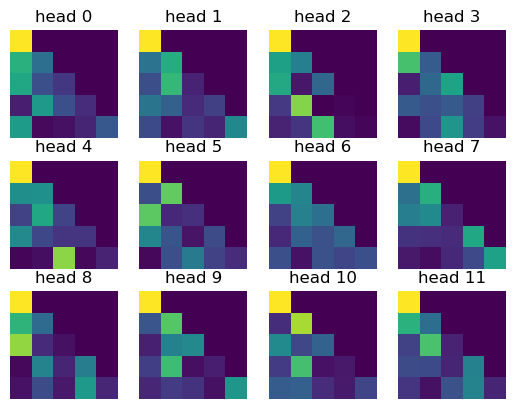

In [138]:
plt.figure()
for head in range(headcnt):
    plt.subplot(3, 4, head + 1)
    plt.imshow(attn_weights_causal[0, head].detach().numpy())
    plt.title(f"head {head}")
    plt.axis("off")
plt.show()

## Transformer Block

Having gaining some intuition about attention layer, let's build it into a transformer. An vanilla transformer block usually looks like this. Note there are slight difference between the transformer blocks in GPT2, BERT and other models, but they generally has the following components

* Transformer Block
  * Layernorm
  * Skip connections
  * Multi-head attention
  * MLP, Feedforward net


## Added / modified section from original

In [139]:
class TransformerBlock_simple(nn.Module):

    def __init__(self, embdim, headcnt, *args, dropout=0.0, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.ln1 = nn.LayerNorm(embdim)
        self.ln2 = nn.LayerNorm(embdim)
        self.attn = nn.MultiheadAttention(embdim, headcnt, batch_first=True,)
        self.ffn = nn.Sequential(
            nn.Linear(embdim, 4 * embdim),
            nn.GELU(),
            nn.Linear(4 * embdim, embdim),
            nn.Dropout(dropout),
        )

    def forward(self, x, is_causal=True):
        batch, token_num, hidden_dim = x.shape
        if is_causal:
            attn_mask = torch.ones(token_num, token_num,)
            attn_mask = -1E4 * torch.triu(attn_mask,1)
        else:
            attn_mask = None

        residue = x
        x = self.ln1(x)
        #### ------ Add your code here: multihead attention ------ ####
        attn_output, attn_weights =  self.attn(x, x, x, attn_mask=attn_mask) # first output is the output latent states
        #### ------ End ------ ####
        x = residue + attn_output

        residue = x
        x = self.ln2(x)
        ffn_output = self.ffn(x)
        output = residue + ffn_output
        return output

Compare the implmentation with the schematics and see if it makes more sense!


*Attention Block*


![BERT (Transformer encoder)](https://iq.opengenus.org/content/images/2020/06/encoder-1.png)


# Image Classification

Now we employ Transformer structure to conduct image classification.

### Imports

In [140]:
!pip install transformers
!pip install torchvision

## Import transformers
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
from transformers import BertModel, BertTokenizer, BertConfig

import os
from os.path import join
from tqdm.notebook import tqdm, trange
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST, CIFAR10
from torchvision import datasets, transforms


### Preparing Image Dataset
Load the dataset, note, the augmentations are necessary. If no augmentation, Transformer will overfit very soon.

In [141]:
!mkdir data
dataset = CIFAR10(root='./data/', train=True, download=True, transform=
transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]))
# augmentations are super important for CNN trainings, or it will overfit very fast without achieving good generalization accuracy
val_dataset = CIFAR10(root='./data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),]))
#%%

mkdir: cannot create directory ‘data’: File exists
Files already downloaded and verified
Files already downloaded and verified


Citing https://openreview.net/pdf?id=SCN8UaetXx,

> "Visual Transformers. Despite some previous work in which attention is used inside the convolutional layers of a CNN [57, 26], the first fully-transformer architectures for vision are iGPT [8] and ViT [17]. The former is trained using a "masked-pixel" self-supervised approach, similar in spirit to the common masked-word task used, for instance, in BERT [15] and in GPT [45] (see below). On the other hand, ViT is trained in a supervised way, using a special "class token" and a classification head attached to the final embedding of this token. Both methods are computationally expensive and, despite their very good results when trained on huge datasets, they underperform ResNet architectures when trained from scratch using only ImageNet-1K [17, 8]. VideoBERT [51] is conceptually similar to iGPT, but, rather than using pixels as tokens, each frame of a video is holistically represented by a feature vector, which is quantized using an off-the-shelf pretrained video classification model. DeiT [53] trains ViT using distillation information provided by a pretrained CNN."

### Transformer model for images

In [142]:
config = BertConfig(hidden_size=256, intermediate_size=1024, num_hidden_layers=12,
                    num_attention_heads=8, max_position_embeddings=256,
                    vocab_size=100, bos_token_id=101, eos_token_id=102,
                    cls_token_id=103, )
model = BertModel(config).cuda()
patch_embed = nn.Conv2d(3, config.hidden_size, kernel_size=4, stride=4).cuda()
CLS_token = nn.Parameter(torch.randn(1, 1, config.hidden_size, device="cuda") / math.sqrt(config.hidden_size))
readout = nn.Sequential(nn.Linear(config.hidden_size, config.hidden_size),
                        nn.GELU(),
                        nn.Linear(config.hidden_size, 10)
                        ).cuda()
for module in [patch_embed, readout, model, CLS_token]:
    module.cuda()

optimizer = AdamW([*model.parameters(),
                   *patch_embed.parameters(),
                   *readout.parameters(),
                   CLS_token], lr=5e-4)

##  Apply correct order of the embedding dimension. ------ ####

In [143]:
batch_size = 192 # 96
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model.train()
loss_list = []
acc_list = []
correct_cnt = 0
total_loss = 0
for epoch in trange(30, leave=False):
    pbar = tqdm(train_loader, leave=False)
    for i, (imgs, labels) in enumerate(pbar):
        patch_embs = patch_embed(imgs.cuda())
        #### ------ Add your code here: replace the None with the correct order of the embedding dimension. ------ ####
        patch_embs = patch_embs.flatten(2).permute(0, 2, 1) # hint: (batch_size, HW, hidden)
        #### ------ End ------ ####
        # print(patch_embs.shape)
        input_embs = torch.cat([CLS_token.expand(imgs.shape[0], 1, -1), patch_embs], dim=1)
        # print(input_embs.shape)
        output = model(inputs_embeds=input_embs)
        logit = readout(output.last_hidden_state[:, 0, :])
        loss = F.cross_entropy(logit, labels.cuda())
        # print(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_description(f"loss: {loss.item():.4f}")
        total_loss += loss.item() * imgs.shape[0]
        correct_cnt += (logit.argmax(dim=1) == labels.cuda()).sum().item()

    loss_list.append(round(total_loss / len(dataset), 4))
    acc_list.append(round(correct_cnt / len(dataset), 4))
    # test on validation set
    model.eval()
    correct_cnt = 0
    total_loss = 0

    for i, (imgs, labels) in enumerate(val_loader):
        patch_embs = patch_embed(imgs.cuda())
        #### ------ Add your code here: replace the None with the correct order of the embedding dimension. ------ ####
        patch_embs = patch_embs.flatten(2).permute(0, 2, 1)  # hint: (batch_size, HW, hidden)
        #### ------ End ------ ####
        input_embs = torch.cat([CLS_token.expand(imgs.shape[0], 1, -1), patch_embs], dim=1)
        output = model(inputs_embeds=input_embs)
        logit = readout(output.last_hidden_state[:, 0, :])
        loss = F.cross_entropy(logit, labels.cuda())
        total_loss += loss.item() * imgs.shape[0]
        correct_cnt += (logit.argmax(dim=1) == labels.cuda()).sum().item()

    print(f"val loss: {total_loss / len(val_dataset):.4f}, val acc: {correct_cnt / len(val_dataset):.4f}")


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.7620, val acc: 0.3370


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.3401, val acc: 0.5053


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.2130, val acc: 0.5606


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.1187, val acc: 0.6044


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.0461, val acc: 0.6147


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.9949, val acc: 0.6345


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.9523, val acc: 0.6664


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.9034, val acc: 0.6831


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.8369, val acc: 0.6985


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7985, val acc: 0.7206


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7495, val acc: 0.7388


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7595, val acc: 0.7348


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7019, val acc: 0.7541


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7457, val acc: 0.7434


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6927, val acc: 0.7613


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6624, val acc: 0.7693


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6653, val acc: 0.7666


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6158, val acc: 0.7854


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6107, val acc: 0.7893


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5986, val acc: 0.7940


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6093, val acc: 0.7973


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5939, val acc: 0.8003


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6080, val acc: 0.7909


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5740, val acc: 0.8109


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5634, val acc: 0.8038


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5548, val acc: 0.8137


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5766, val acc: 0.8075


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5724, val acc: 0.8119


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6056, val acc: 0.8064


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5825, val acc: 0.8149


In [144]:
## ADD PLOTS: TRAINING LOSS CURVE, ACCURACY SCORE CURVE

In [145]:
#### ------ Add your code here: plot the training loss curve to show its variation with the epoch. ------ ####
# hints: use the data in list 'loss_list' and 'acc_list' to plot the curve via plt.plot()
#### ------ End ------ ####

In [146]:
#### ------ Add your code here: plot the accuracy score curve to show its variation with the epoch. ------ ####
# hints: use the data in list 'loss_list' and 'acc_list' to plot the curve via plt.plot()
#### ------ End ------ ####

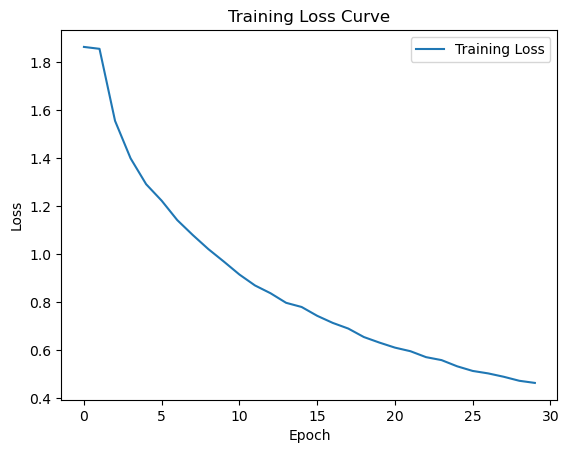

<Figure size 640x480 with 0 Axes>

In [147]:
import matplotlib.pyplot as plt

# Plotting the training loss curve
plt.plot(loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()
plt.savefig('training_loss_curve.png')  # Save the figure




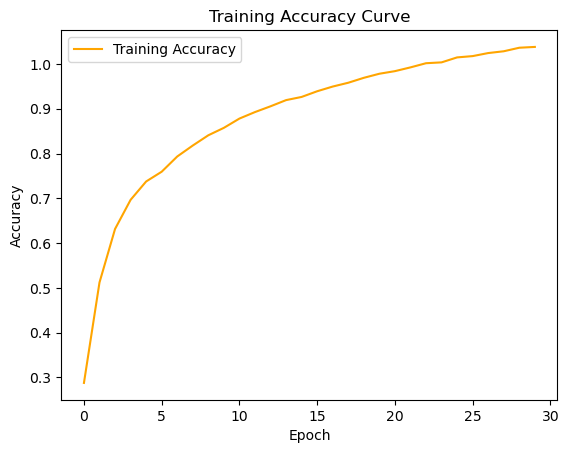

<Figure size 640x480 with 0 Axes>

In [148]:
import matplotlib.pyplot as plt

# Plotting the accuracy curve
plt.plot(acc_list, label='Training Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()
plt.savefig('training_accuracy_curve.png')  # Save the figure


In [149]:
torch.save(model.state_dict(),"bert.pth")
!du -sh bert.pth

37M	bert.pth


**Reference:**
Tutorial for Harvard Medical School ML from Scratch Series: Transformer from Scratch (https://github.com/Animadversio/TransformerFromScratch?tab=readme-ov-file).

In [150]:
import torch
import math

embdim = 256
headdim = 64

tokens = torch.randn(1, 5, embdim)  # batch, tokens, embedding

# Weight matrices for self-attention
Wq = torch.randn(embdim, headdim) / math.sqrt(headdim)  # Corrected dimensions
Wk = torch.randn(embdim, headdim) / math.sqrt(headdim)  # Corrected dimensions
Wv = torch.randn(embdim, headdim) / math.sqrt(headdim)  # Corrected dimensions

# Apply linear transformation to get Q, K, V
Q = torch.matmul(tokens, Wq)
K = torch.matmul(tokens, Wk)
V = torch.matmul(tokens, Wv)


In [151]:
tokens

tensor([[[-0.6474, -1.1879,  0.7224,  ..., -0.6336,  0.4931,  1.7926],
         [ 0.7185, -0.4423,  0.4478,  ..., -0.9908, -0.5125, -1.0700],
         [ 0.5602, -0.4061,  0.0498,  ...,  1.0404,  0.7352, -0.6163],
         [ 0.6510,  0.6880, -1.2009,  ...,  0.8770,  1.1884, -0.5739],
         [-1.3931, -0.7011, -0.7402,  ..., -1.2165, -0.0313,  0.0961]]])

In [152]:
import numpy as np

def self_attention(Q, K, V):
    # Calculate the attention scores
    attention_scores = np.dot(Q, K.T) / np.sqrt(Q.shape[-1])

    # Apply softmax to get attention weights
    attention_weights = softmax(attention_scores, axis=-1)

    # Apply the attention weights to the values
    attention_output = np.dot(attention_weights, V)

    return attention_output

def softmax(x, axis=-1):
    # Numerically stable softmax function
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

# Example usage
input_size = 768
sequence_length = 6

# Random input matrices Q, K, and V
Q = np.random.rand(input_size, sequence_length)
K = np.random.rand(input_size, sequence_length)
V = np.random.rand(input_size, sequence_length)

# Apply self-attention
attention_output = self_attention(Q, K, V)

# Print the dimensions of the output
print("Output dimensions:", attention_output.shape)


Output dimensions: (768, 6)


In [153]:
Q_dim = Q.shape
Q_dim

(768, 6)